In [19]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.tools.monitor import *
from scipy.linalg import expm
import matplotlib.pyplot as plt
from ibm_quantum_widgets import CircuitComposer

import time

from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeQuito

from qiskit.providers.ibmq import least_busy

%matplotlib inline



# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-06-14 05:37:17,259: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
#### Exact Time Dynamics
## Pauli matrices

S_x = np.matrix([[0.0,1.0],[1.0,0.0]])
S_y = np.matrix([[0.0,-1.0j],[1.0j,0.0]])
S_z = np.matrix([[1.0,0.0],[0.0,-1.0]])
Id = np.matrix([[1.0,0.0],[0.0,1.0]])

## Single qubit states 0 and 1 in computational basis
vect_0 = np.matrix([[1.0],[0.0]])
vect_1 = np.matrix([[0.0],[1.0]])



In [12]:
## The Schwinger model parameters
mu = 0.1
x = 0.6

In [13]:
## Unitarytime evolution operator under H

def U_exact(t,x,mu):
    H = (x/np.sqrt(2))*np.kron(S_x,S_x) + (x/np.sqrt(2))*np.kron(S_y,S_y) - mu*np.kron(S_z,S_z) +\
    x*(1.0 + (1.0/np.sqrt(2)))*np.kron(Id,S_x) - 0.5*np.kron(Id,S_z) - (1.0 + mu)*np.kron(S_z,Id) +\
    x*(1.0 - (1.0/np.sqrt(2)))*np.kron(S_z, S_x)
    return expm(-1.0j*t*H)


Probability 01 =  [0.0, 0.014279532227667731, 0.05569589690867274, 0.1201536813864746, 0.20137353020348137, 0.2916295751523156, 0.38263162083894314, 0.4664317568927078, 0.5362372307766643, 0.587031522308546, 0.6159394179540106, 0.6223130899996523, 0.607557410658409, 0.5747471148374631, 0.528110837539648, 0.4724649524394642, 0.4126738840283906, 0.3531961238930574, 0.2977513311140845, 0.2491191063043279]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

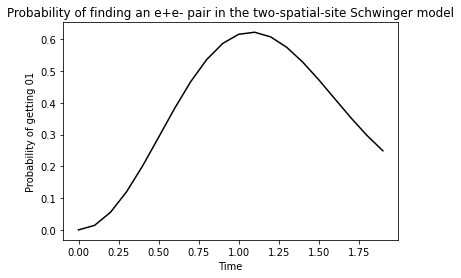

In [14]:
# time step
dt = 0.1
# number of time steps
NSteps = 20
nSteps = [n for n in range(NSteps)]

# initial state
v00 = np.kron(vect_0,vect_0)
# electron-positron pair state
v01 = np.kron(vect_0,vect_1)

P01_exact = []

for j in range(NSteps):
    t = nSteps[j]*dt
    res = np.transpose(v01)*U_exact(t,x,mu)*v00
    P01_exact.append(np.abs(res[0,0])**2)
    
print('Probability 01 = ', P01_exact)
Time = dt*np.arange(0,NSteps,1)
plt.plot(Time, P01_exact, 'black')
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')  
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

In [15]:
#### Trotterized Time Dynamics with Qiskit

# registers and quantum circuit
q = QuantumRegister(2,'q')
c = ClassicalRegister(2, 'c')
circ = QuantumCircuit(q,c)

# single first order Trotter step circuit
def U_trot(dt,q):
    circ.rxx(-2.0*(x/np.sqrt(2))*dt, 0, 1) 
    circ.sdg(q)
    circ.rxx(-2.0*(x/np.sqrt(2)*dt), 0, 1)
    circ.s(q)
    circ.h(q)
    circ.rxx(2.0*mu*dt, 0, 1) 
    circ.h(q)
    circ.rx(-2.0*x*(1.0 + (1.0/np.sqrt(2)))*dt, 1)
    circ.rz(1.0*dt, 1) 
    circ.rz(2.0*(1.0 + mu)*dt, 0)
    circ.h(0)
    circ.rxx(-2.0*x*(1.0 - (1.0/np.sqrt(2)))*dt, 0, 1) 
    circ.h(0)
    return circ

# approximate unitary propagator for t = dt*nSteps
def U_approx(circ, dt, nSteps, q):
    if nSteps>0:
        for ind in range(nSteps): 
            circ = U_trot(dt, q)  
    else: 
        circ = U_trot(0,q)
    return circ
    


Probability 01 =  [8.024582750190568e-32, 0.014313156771279416, 0.056026902699410464, 0.12129368419059881, 0.20398326507098963, 0.29639051486161255, 0.39011053854319555, 0.47696159768404267, 0.5498342224999619, 0.6033615686009527, 0.6343378778320995, 0.6418528090240887, 0.6271520713363146, 0.5932720056577452, 0.5445217666459916, 0.4858982665517088, 0.42251568446160365, 0.3591155418376728, 0.299699617579819, 0.24730186704778465]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

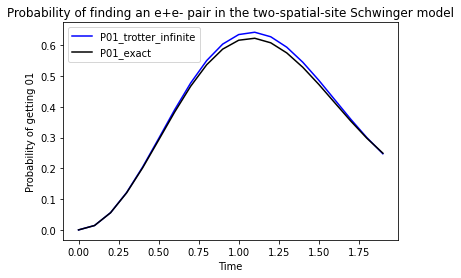

In [16]:
#### Infinite number of measurements
# time step
dt = 0.1
# number of time steps
NSteps = 20
nSteps = [n for n in range(NSteps)]
# number of measurements per task
nShots = 0

P01_trotter = []

# Select local simulator as backend device (statevector)
backend = Aer.get_backend('statevector_simulator')

# run 20 time steps
for j in range(NSteps):
    circ = QuantumCircuit(2,2) # initialize a quantum circuit
    circ = U_approx(circ, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    job = execute(circ, backend, shots = nShots) 
    result = job.result() # collect run results
    outputstatee = result.get_statevector(circ) 
    P01_trotter.append(np.abs(outputstatee[2])**2) 

print('Probability 01 = ', P01_trotter)

Time = dt*np.arange(0,NSteps,1)

plt.plot(Time, P01_trotter, 'blue', label='P01_trotter_infinite')
plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')  
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')



Time per time step= [0.025294065475463867, 0.03388667106628418, 0.038112640380859375, 0.044569969177246094, 0.06107211112976074, 0.06661748886108398, 0.07650971412658691, 0.1060492992401123, 0.10832500457763672, 0.1141519546508789, 0.13885235786437988, 0.14857053756713867, 0.14336585998535156, 0.15508341789245605, 0.1643989086151123, 0.17479968070983887, 0.1921520233154297, 0.21721506118774414, 0.1977527141571045, 0.21380949020385742]

Total time= 2.4210822582244873

Probability 01 =  [0, 0.026000000000000002, 0.04, 0.122, 0.18, 0.296, 0.402, 0.48, 0.52, 0.638, 0.616, 0.636, 0.628, 0.584, 0.514, 0.462, 0.42, 0.38, 0.28, 0.244]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

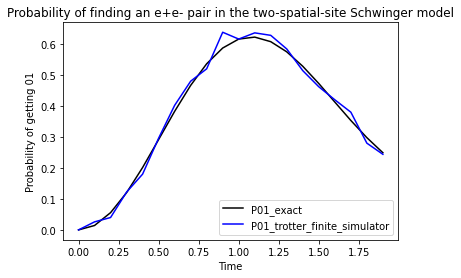

In [17]:
#### Finite measurements statistics on a quantum computer simulator / dt = 0.1
# time step
dt = 0.1
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_sim = []
time_per_step_sim = []

# Select Local simulator as a backend device 
backend = Aer.get_backend('qasm_simulator')

# run 20 time steps

timer_1_sim = time.time()

for j in range(NSteps):
    timer_2_sim = time.time()
    circ = QuantumCircuit(2,2) # initialize a quantum circuit
    circ = U_approx(circ, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ.z(q)
    circ.measure(range(2),range(2)) # mesure 
    job = execute(circ, backend, shots=nShots) # creation a quantum task and run 
    result = job.result() # collect run results
    count = result.get_counts(circ)
    
    try:
        var = count.get('10')
        P01_trotter_finite_sim.append((1.0/nShots)*var)
    except:
        P01_trotter_finite_sim.append(0)
    
    time_2_sim = time.time() - timer_2_sim
    time_per_step_sim.append(time_2_sim)
    
    
time_1_sim = time.time() - timer_1_sim
print('Time per time step=', time_per_step_sim)
print('\nTotal time=', time_1_sim)
print('\nProbability 01 = ', P01_trotter_finite_sim)


Time = dt*np.arange(0,NSteps,1)

plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')


Time per time step= [155.5504207611084, 117.7296552658081, 96.92554378509521, 63.98789572715759, 64.34289598464966, 20.487993955612183, 76.9454734325409, 105.7879147529602, 100.01381063461304, 77.05208420753479, 62.0868399143219, 60.74694514274597, 115.2065908908844, 92.20857644081116, 79.0713620185852, 65.41893863677979, 65.9279899597168, 66.24672031402588, 92.26849317550659, 100.00123286247253]

Total time= 1678.007783651352
Probability on real quantum device 01 =  [0.216, 0.224, 0.334, 0.302, 0.334, 0.258, 0.254, 0.28800000000000003, 0.298, 0.28800000000000003, 0.272, 0.26, 0.266, 0.242, 0.216, 0.272, 0.218, 0.224, 0.242, 0.21]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

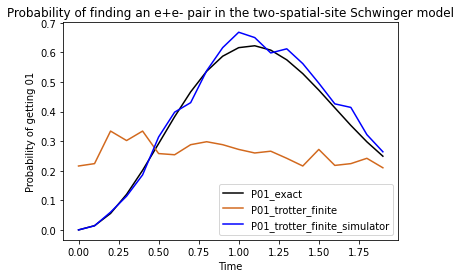

In [23]:
#### Finite measurements statistics on real quantum computer (ibmq_quito) / dt = 0.1
# time step
dt = 0.1
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_real_quito = []
time_per_step_quito = []

# Select Local simulator as a backend device 
#backend_real = least_busy(provider.backends(operational=True, simulator=False, status_msg='active',
                                           # filters=lambda x:x.configuration().n_qubits>1))
backend_real =provider.get_backend('ibmq_quito')

# run 20 time steps

timer_1_quito = time.time()

for j in range(NSteps):
    timer_2_quito = time.time()
    circ_real = QuantumCircuit(2,2) # initialize a quantum circuit
    circ_real = U_approx(circ_real, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ_real.z(q)
    circ_real.measure(range(2), range(2)) # mesure  
    job_real = execute(circ_real, backend_real, shots=nShots) # creation a quantum task and run 
    result_real = job_real.result() # collect run results
    count_real = result_real.get_counts(circ_real)
    
    try:
        var_real = count_real.get('10')
        P01_trotter_finite_real_quito.append((1.0/nShots)*var_real)
    except: 
        P01_trotter_finite_real_quito.append(0) 
    
    time_2_quito = time.time() - timer_2_quito
    time_per_step_quito.append(time_2_quito)
    
time_1_quito = time.time() - timer_1_quito
print('Time per time step=', time_per_step_quito)
print('\nTotal time=', time_1_quito)
        
print('Probability on real quantum device 01 = ', P01_trotter_finite_real_quito )


Time = dt*np.arange(0,NSteps,1)

plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_real_quito, 'chocolate', label='P01_trotter_finite')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Time per time step= [79.8660900592804, 108.79134345054626, 104.37300610542297, 106.87412548065186, 102.27701473236084, 111.78189945220947, 108.22640037536621, 105.65784239768982, 104.30305886268616, 126.77196455001831, 106.12033891677856, 109.61371612548828, 109.51424479484558, 110.55770778656006, 109.30282950401306, 111.41803574562073, 109.07475852966309, 118.86612010002136, 124.85306334495544, 113.43967247009277]

Total time= 2181.683617591858
Probability on real quantum device 01 =  [0.316, 0.232, 0.222, 0.298, 0.28800000000000003, 0.28200000000000003, 0.28800000000000003, 0.278, 0.28200000000000003, 0.264, 0.224, 0.298, 0.268, 0.28200000000000003, 0.252, 0.268, 0.248, 0.23600000000000002, 0.276, 0.244]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

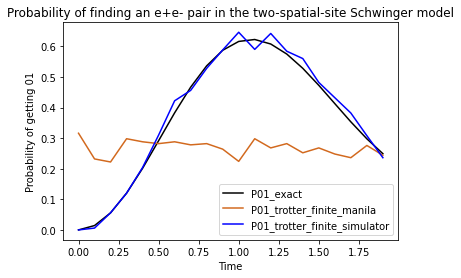

In [26]:
#### Finite measurements statistics on real quantum computer (ibmq_manila) / dt = 0.1
# time step
dt = 0.1
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_real_manila = []
time_per_step_manila = []

# Select Local simulator as a backend device 
#backend_real = least_busy(provider.backends(operational=True, simulator=False, status_msg='active',
                                           # filters=lambda x:x.configuration().n_qubits>1))
backend_real =provider.get_backend('ibmq_manila')

# run 20 time steps

timer_1_manila = time.time()

for j in range(NSteps):
    timer_2_manila = time.time()
    circ_real = QuantumCircuit(2,2) # initialize a quantum circuit
    circ_real = U_approx(circ_real, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ_real.z(q)
    circ_real.measure(range(2), range(2)) # mesure  
    job_real = execute(circ_real, backend_real, shots=nShots) # creation a quantum task and run 
    result_real = job_real.result() # collect run results
    count_real = result_real.get_counts(circ_real)
    
    try:
        var_real = count_real.get('10')
        P01_trotter_finite_real_manila.append((1.0/nShots)*var_real)
    except: 
        P01_trotter_finite_real_manila.append(0) 
    
    time_2_manila = time.time() - timer_2_manila
    time_per_step_manila.append(time_2_manila)
    
time_1_manila = time.time() - timer_1_manila
print('Time per time step=', time_per_step_manila)
print('\nTotal time=', time_1_manila)
        
print('Probability on real quantum device 01 = ', P01_trotter_finite_real_manila )


Time = dt*np.arange(0,NSteps,1)

plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_real_manila, 'chocolate', label='P01_trotter_finite_manila')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Text(0.5, 1.0, 'Comparison of the time per time step')

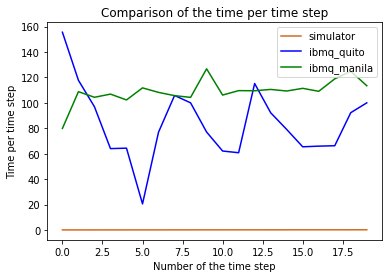

In [27]:
# Comparison between the different devices for the time per time step / dt = 0.1
plt.plot(nSteps, time_per_step_sim, 'chocolate', label='simulator')
plt.plot(nSteps, time_per_step_quito, 'blue', label='ibmq_quito')
plt.plot(nSteps, time_per_step_manila, 'green', label='ibmq_manila')
plt.legend()
plt.xlabel('Number of the time step')
plt.ylabel('Time per time step')
plt.title('Comparison of the time per time step')


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

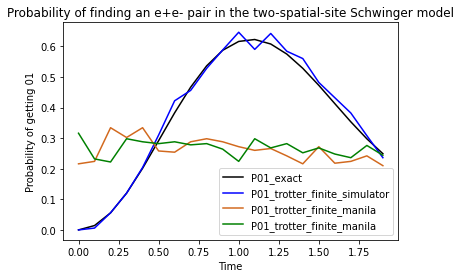

In [28]:
# Comparison between the different devices for P01 / dt = 0.1
plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.plot(Time, P01_trotter_finite_real_quito, 'chocolate', label='P01_trotter_finite_manila')
plt.plot(Time, P01_trotter_finite_real_manila, 'green', label='P01_trotter_finite_manila')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Time per time step= [0.016678571701049805, 0.023101091384887695, 0.022361278533935547, 0.027817487716674805, 0.034265995025634766, 0.03819632530212402, 0.04350399971008301, 0.052246809005737305, 0.05659317970275879, 0.0650932788848877, 0.06827974319458008, 0.07340884208679199, 0.07993483543395996, 0.08452010154724121, 0.09091591835021973, 0.09536314010620117, 0.10186409950256348, 0.10943913459777832, 0.11457443237304688, 0.12134575843811035]

Total time= 1.3198456764221191

Probability 01 =  [0, 0, 0.002, 0.004, 0, 0, 0.008, 0.008, 0, 0.016, 0.016, 0.022, 0.026000000000000002, 0.024, 0.03, 0.034, 0.018000000000000002, 0.028, 0.064, 0.052000000000000005]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

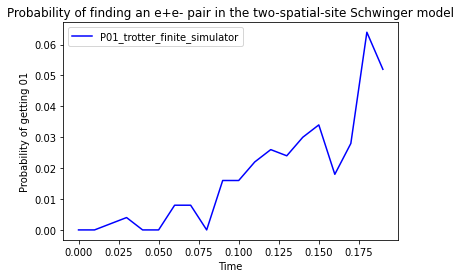

In [31]:
#### Finite measurements statistics on a quantum computer simulator / dt = 0.01
# time step
dt = 0.01
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_sim = []
time_per_step_sim = []

# Select Local simulator as a backend device 
backend = Aer.get_backend('qasm_simulator')

# run 20 time steps

timer_1_sim = time.time()

for j in range(NSteps):
    timer_2_sim = time.time()
    circ = QuantumCircuit(2,2) # initialize a quantum circuit
    circ = U_approx(circ, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ.z(q)
    circ.measure(range(2),range(2)) # mesure 
    job = execute(circ, backend, shots=nShots) # creation a quantum task and run 
    result = job.result() # collect run results
    count = result.get_counts(circ)
    
    try:
        var = count.get('10')
        P01_trotter_finite_sim.append((1.0/nShots)*var)
    except:
        P01_trotter_finite_sim.append(0)
    
    time_2_sim = time.time() - timer_2_sim
    time_per_step_sim.append(time_2_sim)
    
    
time_1_sim = time.time() - timer_1_sim
print('Time per time step=', time_per_step_sim)
print('\nTotal time=', time_1_sim)
print('\nProbability 01 = ', P01_trotter_finite_sim)


Time = dt*np.arange(0,NSteps,1)

#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')


Time per time step= [16.53693461418152, 65.25107741355896, 11.026765584945679, 61.917826890945435, 63.397069215774536, 73.63024115562439, 64.65648770332336, 12.774056911468506, 64.02447628974915, 79.9642686843872, 68.18988704681396, 64.09642601013184, 77.4569160938263, 65.46481442451477, 146.38184094429016, 86.82332134246826, 77.43492674827576, 66.55692553520203, 65.80824422836304, 93.053475856781]

Total time= 1324.4463908672333
Probability on real quantum device 01 =  [0.302, 0.258, 0.296, 0.29, 0.266, 0.264, 0.26, 0.276, 0.308, 0.28200000000000003, 0.3, 0.276, 0.244, 0.24, 0.256, 0.244, 0.23600000000000002, 0.244, 0.258, 0.212]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

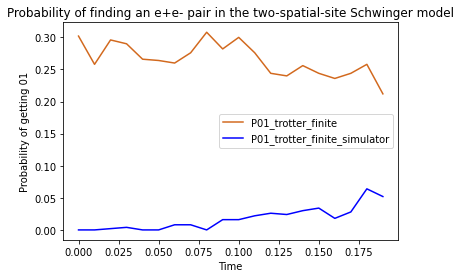

In [32]:
#### Finite measurements statistics on real quantum computer (ibmq_quito) / dt = 0.01
# time step
dt = 0.01
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_real_quito = []
time_per_step_quito = []

# Select Local simulator as a backend device 
#backend_real = least_busy(provider.backends(operational=True, simulator=False, status_msg='active',
                                           # filters=lambda x:x.configuration().n_qubits>1))
backend_real =provider.get_backend('ibmq_quito')

# run 20 time steps

timer_1_quito = time.time()

for j in range(NSteps):
    timer_2_quito = time.time()
    circ_real = QuantumCircuit(2,2) # initialize a quantum circuit
    circ_real = U_approx(circ_real, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ_real.z(q)
    circ_real.measure(range(2), range(2)) # mesure  
    job_real = execute(circ_real, backend_real, shots=nShots) # creation a quantum task and run 
    result_real = job_real.result() # collect run results
    count_real = result_real.get_counts(circ_real)
    
    try:
        var_real = count_real.get('10')
        P01_trotter_finite_real_quito.append((1.0/nShots)*var_real)
    except: 
        P01_trotter_finite_real_quito.append(0) 
    
    time_2_quito = time.time() - timer_2_quito
    time_per_step_quito.append(time_2_quito)
    
time_1_quito = time.time() - timer_1_quito
print('Time per time step=', time_per_step_quito)
print('\nTotal time=', time_1_quito)
        
print('Probability on real quantum device 01 = ', P01_trotter_finite_real_quito )


Time = dt*np.arange(0,NSteps,1)

#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_real_quito, 'chocolate', label='P01_trotter_finite')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Time per time step= [113.98089098930359, 115.55357646942139, 111.04275345802307, 107.44738101959229, 272.1986258029938, 133.67610621452332, 122.07976388931274, 132.16612076759338, 111.74351835250854, 141.0574927330017, 112.52380228042603, 113.59800815582275, 124.33746266365051, 118.59211945533752, 133.00266790390015, 139.01481676101685, 116.19767355918884, 118.30616188049316, 121.93092703819275, 140.21644639968872]

Total time= 2598.666721343994
Probability on real quantum device 01 =  [0.254, 0.276, 0.272, 0.24, 0.304, 0.252, 0.228, 0.27, 0.292, 0.296, 0.252, 0.254, 0.272, 0.242, 0.21, 0.244, 0.256, 0.28800000000000003, 0.262, 0.23800000000000002]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

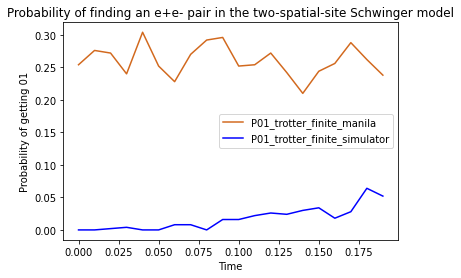

In [34]:
#### Finite measurements statistics on real quantum computer (ibmq_manila) / dt = 0.01
# time step
dt = 0.01
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_real_manila = []
time_per_step_manila = []

# Select Local simulator as a backend device 
#backend_real = least_busy(provider.backends(operational=True, simulator=False, status_msg='active',
                                           # filters=lambda x:x.configuration().n_qubits>1))
backend_real =provider.get_backend('ibmq_manila')

# run 20 time steps

timer_1_manila = time.time()

for j in range(NSteps):
    timer_2_manila = time.time()
    circ_real = QuantumCircuit(2,2) # initialize a quantum circuit
    circ_real = U_approx(circ_real, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ_real.z(q)
    circ_real.measure(range(2), range(2)) # mesure  
    job_real = execute(circ_real, backend_real, shots=nShots) # creation a quantum task and run 
    result_real = job_real.result() # collect run results
    count_real = result_real.get_counts(circ_real)
    
    try:
        var_real = count_real.get('10')
        P01_trotter_finite_real_manila.append((1.0/nShots)*var_real)
    except: 
        P01_trotter_finite_real_manila.append(0) 
    
    time_2_manila = time.time() - timer_2_manila
    time_per_step_manila.append(time_2_manila)
    
time_1_manila = time.time() - timer_1_manila
print('Time per time step=', time_per_step_manila)
print('\nTotal time=', time_1_manila)
        
print('Probability on real quantum device 01 = ', P01_trotter_finite_real_manila )


Time = dt*np.arange(0,NSteps,1)

#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_real_manila, 'chocolate', label='P01_trotter_finite_manila')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Text(0.5, 1.0, 'Comparison of the time per time step')

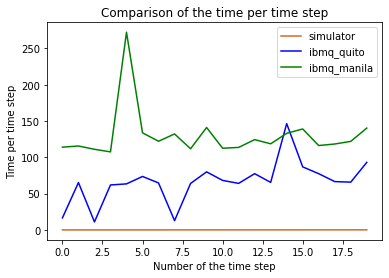

In [35]:
# Comparison between the different devices for the time per time step / dt = 0.01
plt.plot(nSteps, time_per_step_sim, 'chocolate', label='simulator')
plt.plot(nSteps, time_per_step_quito, 'blue', label='ibmq_quito')
plt.plot(nSteps, time_per_step_manila, 'green', label='ibmq_manila')
plt.legend()
plt.xlabel('Number of the time step')
plt.ylabel('Time per time step')
plt.title('Comparison of the time per time step')


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

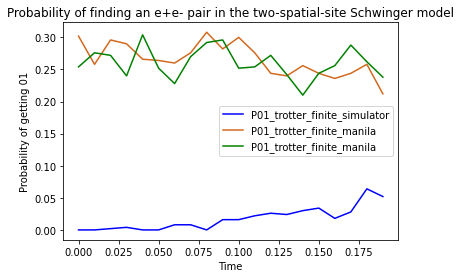

In [37]:
# Comparison between the different devices for P01 / dt = 0.1
#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.plot(Time, P01_trotter_finite_real_quito, 'chocolate', label='P01_trotter_finite_manila')
plt.plot(Time, P01_trotter_finite_real_manila, 'green', label='P01_trotter_finite_manila')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Time per time step= [0.016068220138549805, 0.014875650405883789, 0.020527124404907227, 0.026544809341430664, 0.03455233573913574, 0.041472434997558594, 0.047245025634765625, 0.05146217346191406, 0.05669689178466797, 0.06295418739318848, 0.06966352462768555, 0.07494354248046875, 0.08190393447875977, 0.08589625358581543, 0.09678077697753906, 0.09969091415405273, 0.10639071464538574, 0.11047530174255371, 0.1227259635925293, 0.12767410278320312]

Total time= 1.3489296436309814

Probability 01 =  [0, 0.322, 0.71, 0.5660000000000001, 0.21, 0.108, 0.116, 0.162, 0.216, 0.522, 0.624, 0.194, 0.008, 0.34600000000000003, 0.5760000000000001, 0.47400000000000003, 0.184, 0.112, 0.15, 0.05]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

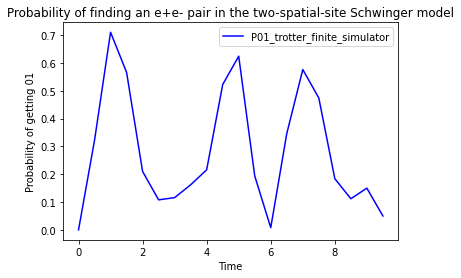

In [38]:
#### Finite measurements statistics on a quantum computer simulator / dt = 0.5
# time step
dt = 0.5
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_sim = []
time_per_step_sim = []

# Select Local simulator as a backend device 
backend = Aer.get_backend('qasm_simulator')

# run 20 time steps

timer_1_sim = time.time()

for j in range(NSteps):
    timer_2_sim = time.time()
    circ = QuantumCircuit(2,2) # initialize a quantum circuit
    circ = U_approx(circ, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ.z(q)
    circ.measure(range(2),range(2)) # mesure 
    job = execute(circ, backend, shots=nShots) # creation a quantum task and run 
    result = job.result() # collect run results
    count = result.get_counts(circ)
    
    try:
        var = count.get('10')
        P01_trotter_finite_sim.append((1.0/nShots)*var)
    except:
        P01_trotter_finite_sim.append(0)
    
    time_2_sim = time.time() - timer_2_sim
    time_per_step_sim.append(time_2_sim)
    
    
time_1_sim = time.time() - timer_1_sim
print('Time per time step=', time_per_step_sim)
print('\nTotal time=', time_1_sim)
print('\nProbability 01 = ', P01_trotter_finite_sim)


Time = dt*np.arange(0,NSteps,1)

#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Time per time step= [45.94595217704773, 24.61702609062195, 63.522095918655396, 63.03543162345886, 23.952641010284424, 40.94450926780701, 31.487589836120605, 40.114315032958984, 35.754149436950684, 50.56318783760071, 24.769981622695923, 48.80560755729675, 26.074714422225952, 48.48898386955261, 24.988389253616333, 64.82839512825012, 32.16275501251221, 16.969526052474976, 33.18916368484497, 19.06809949874878]

Total time= 759.2829375267029
Probability on real quantum device 01 =  [0.202, 0.28400000000000003, 0.28800000000000003, 0.23, 0.242, 0.20800000000000002, 0.196, 0.23800000000000002, 0.20600000000000002, 0.256, 0.244, 0.242, 0.22, 0.246, 0.23600000000000002, 0.23, 0.21, 0.23, 0.20600000000000002, 0.2]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

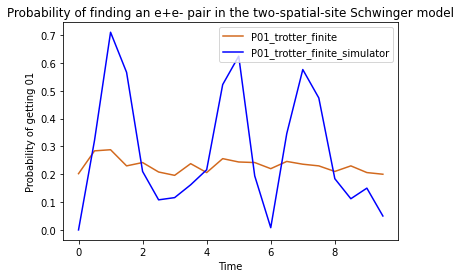

In [39]:
#### Finite measurements statistics on real quantum computer (ibmq_quito) / dt = 0.5
# time step
dt = 0.5
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_real_quito = []
time_per_step_quito = []

# Select Local simulator as a backend device 
#backend_real = least_busy(provider.backends(operational=True, simulator=False, status_msg='active',
                                           # filters=lambda x:x.configuration().n_qubits>1))
backend_real =provider.get_backend('ibmq_quito')

# run 20 time steps

timer_1_quito = time.time()

for j in range(NSteps):
    timer_2_quito = time.time()
    circ_real = QuantumCircuit(2,2) # initialize a quantum circuit
    circ_real = U_approx(circ_real, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ_real.z(q)
    circ_real.measure(range(2), range(2)) # mesure  
    job_real = execute(circ_real, backend_real, shots=nShots) # creation a quantum task and run 
    result_real = job_real.result() # collect run results
    count_real = result_real.get_counts(circ_real)
    
    try:
        var_real = count_real.get('10')
        P01_trotter_finite_real_quito.append((1.0/nShots)*var_real)
    except: 
        P01_trotter_finite_real_quito.append(0) 
    
    time_2_quito = time.time() - timer_2_quito
    time_per_step_quito.append(time_2_quito)
    
time_1_quito = time.time() - timer_1_quito
print('Time per time step=', time_per_step_quito)
print('\nTotal time=', time_1_quito)
        
print('Probability on real quantum device 01 = ', P01_trotter_finite_real_quito )


Time = dt*np.arange(0,NSteps,1)

#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_real_quito, 'chocolate', label='P01_trotter_finite')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Time per time step= [263.7103159427643, 103.99025583267212, 98.14705753326416, 114.01992011070251, 103.57201218605042, 167.54170393943787, 107.4693763256073, 121.7631778717041, 86.60234022140503, 101.79620575904846, 86.88854908943176, 92.29640793800354, 117.89300894737244, 129.59703540802002, 117.19768118858337, 90.59140133857727, 93.27845096588135, 92.03774285316467, 91.09199547767639, 94.42492341995239]

Total time= 2273.909971475601
Probability on real quantum device 01 =  [0.28600000000000003, 0.244, 0.302, 0.308, 0.264, 0.23600000000000002, 0.21, 0.232, 0.292, 0.278, 0.298, 0.28, 0.28200000000000003, 0.266, 0.248, 0.246, 0.262, 0.224, 0.264, 0.25]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

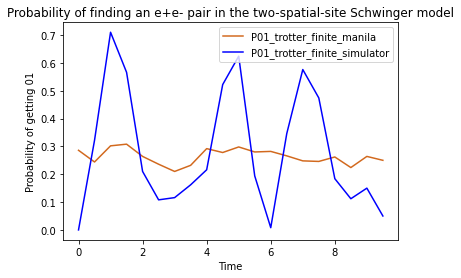

In [40]:
#### Finite measurements statistics on real quantum computer (ibmq_manila) / dt = 0.5
# time step
dt = 0.5
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_real_manila = []
time_per_step_manila = []

# Select Local simulator as a backend device 
#backend_real = least_busy(provider.backends(operational=True, simulator=False, status_msg='active',
                                           # filters=lambda x:x.configuration().n_qubits>1))
backend_real =provider.get_backend('ibmq_manila')

# run 20 time steps

timer_1_manila = time.time()

for j in range(NSteps):
    timer_2_manila = time.time()
    circ_real = QuantumCircuit(2,2) # initialize a quantum circuit
    circ_real = U_approx(circ_real, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ_real.z(q)
    circ_real.measure(range(2), range(2)) # mesure  
    job_real = execute(circ_real, backend_real, shots=nShots) # creation a quantum task and run 
    result_real = job_real.result() # collect run results
    count_real = result_real.get_counts(circ_real)
    
    try:
        var_real = count_real.get('10')
        P01_trotter_finite_real_manila.append((1.0/nShots)*var_real)
    except: 
        P01_trotter_finite_real_manila.append(0) 
    
    time_2_manila = time.time() - timer_2_manila
    time_per_step_manila.append(time_2_manila)
    
time_1_manila = time.time() - timer_1_manila
print('Time per time step=', time_per_step_manila)
print('\nTotal time=', time_1_manila)
        
print('Probability on real quantum device 01 = ', P01_trotter_finite_real_manila )


Time = dt*np.arange(0,NSteps,1)

#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_real_manila, 'chocolate', label='P01_trotter_finite_manila')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Text(0.5, 1.0, 'Comparison of the time per time step')

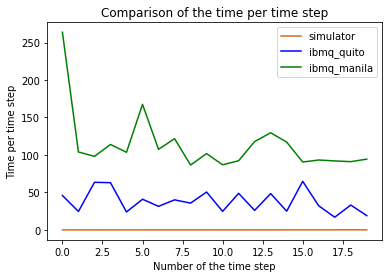

In [41]:
# Comparison between the different devices for the time per time step / dt = 0.5
plt.plot(nSteps, time_per_step_sim, 'chocolate', label='simulator')
plt.plot(nSteps, time_per_step_quito, 'blue', label='ibmq_quito')
plt.plot(nSteps, time_per_step_manila, 'green', label='ibmq_manila')
plt.legend()
plt.xlabel('Number of the time step')
plt.ylabel('Time per time step')
plt.title('Comparison of the time per time step')

Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

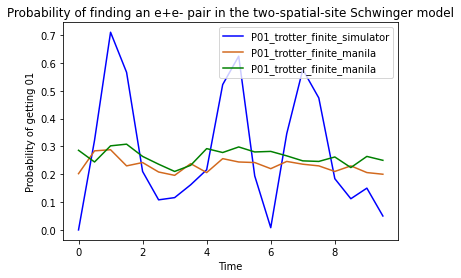

In [42]:
# Comparison between the different devices for P01 / dt = 0.1
#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.plot(Time, P01_trotter_finite_real_quito, 'chocolate', label='P01_trotter_finite_manila')
plt.plot(Time, P01_trotter_finite_real_manila, 'green', label='P01_trotter_finite_manila')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

Time per time step= [4.663775205612183, 4.224210977554321, 4.504308700561523, 4.528093099594116, 6.267595291137695, 6.049917221069336, 7.534259080886841, 8.446330070495605, 9.914304494857788, 12.270144939422607, 13.619596004486084, 16.546765089035034, 16.584278345108032, 19.227476358413696, 22.194252490997314, 25.98993444442749, 27.80918598175049, 29.696324586868286, 34.424553632736206, 37.88235640525818]

Total time= 312.37836027145386
Probability on real quantum device 01 =  [0.578, 0.536, 0.59, 0.55, 0.5700000000000001, 0.592, 0.544, 0.604, 0.536, 0.53, 0.578, 0.512, 0.58, 0.562, 0.582, 0.5680000000000001, 0.526, 0.5660000000000001, 0.526, 0.5760000000000001]


Text(0.5, 1.0, 'Probability of finding an e+e- pair in the two-spatial-site Schwinger model')

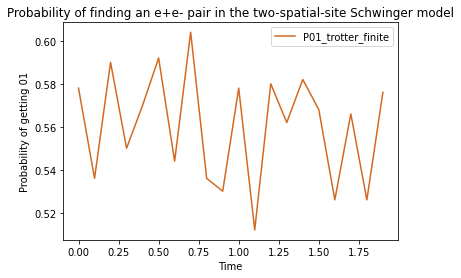

In [20]:
# Noise simulation on fake ibmq_quito
#### Finite measurements statistics 
# time step
dt = 0.1
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite_fake_quito = []
time_per_step_quito = []

# Select backend device 
backend_fake = FakeQuito()
sim_quito = AerSimulator.from_backend(backend_fake)

# run 20 time steps

timer_1_quito = time.time()

for j in range(NSteps):
    timer_2_quito = time.time()
    circ_fake = QuantumCircuit(2,2) # initialize a quantum circuit
    circ_fake = U_approx(circ_fake, dt, nSteps[j], q) # append the trotterized time dynamics circuit
    circ_fake.z(q)
    circ_fake.measure(range(2), range(2)) # mesure  
    tcirc = transpile(circ_fake, sim_quito)
    result_noise = sim_quito.run(tcirc).result()
    counts_noise = result_noise.get_counts(tcirc)
    
    try:
        var_noise = counts_noise.get('10')
        P01_trotter_finite_fake_quito.append((1.0/nShots)*var_noise)
    except: 
        P01_trotter_finite_fake_quito.append(0) 
    
    time_2_quito = time.time() - timer_2_quito
    time_per_step_quito.append(time_2_quito)
    
time_1_quito = time.time() - timer_1_quito
print('Time per time step=', time_per_step_quito)
print('\nTotal time=', time_1_quito)
        
print('Probability on real quantum device 01 = ', P01_trotter_finite_fake_quito )


Time = dt*np.arange(0,NSteps,1)

#plt.plot(Time, P01_exact, 'black', label='P01_exact')
plt.plot(Time, P01_trotter_finite_fake_quito, 'chocolate', label='P01_trotter_finite')
#plt.plot(Time, P01_trotter_finite_sim, 'blue', label='P01_trotter_finite_simulator')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Probability of getting 01')
plt.title('Probability of finding an e+e- pair in the two-spatial-site Schwinger model')